## Penambahan terbaru

1.   Tetap dimasukkan Normalisasi Awal (hard-code) sebagai perbandingan
2.   Kemudian dilakukan pencarian angka normalisasi (disebut kalibrasi) dengan statistik deskriptif (min, max, persentil 95 latency)
3. Perubahan parameter skenario agar lebih ekstrem, agar terlihat perbedaan dengan normalisasi yang :

Old:
- **Lighting**: Penurunan brightness (factor=0.1)
- **Blur**: Gaussian blur (radius=2.0)  
- **Compression**: JPEG compression (quality=25)
- **Noise**: Gaussian noise (sigma=15.0)

New:
- **Lighting**: Penurunan brightness (factor=0.01)
- **Blur**: Gaussian blur (radius=10.0)  
- **Compression**: JPEG compression (quality=2)
- **Noise**: Gaussian noise (sigma=100.0)

** Note: Beberapa skenario berubah dari degrade-> ke healthy karena punya latency yang baik dibanding baseline, jadi jika mau dianggap degraded, bobot latency bisa dikurangi


# Multi-Metrics Monitoring — Composite Score (D_prod)

Notebook ini fokus ke **multi metrics** (PSI, KL, class shift, confidence ratio, latency) dan menghitung **Composite Health Score (D_prod)** untuk beberapa skenario.

In [ ]:
# (Opsional) Install dependencies jika jalan di Colab
# !pip install -q torch torchvision scikit-learn tqdm numpy pandas matplotlib pillow scipy

import os, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from PIL import ImageEnhance, ImageFilter, Image
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from PIL import ImageEnhance
import random

In [ ]:
# ==============================
# INIT MULTI-METRIC TIME-SERIES COLLECTOR
# ==============================
multi_timeseries_records = []

## 1) Helper Metrics: PSI, KL, Class Shift, Confidence Ratio, Latency

In [ ]:
def clamp01(x: float) -> float:
    return max(0.0, min(1.0, float(x)))

def compute_hist(prob_array: np.ndarray, n_bins: int = 10):
    hist, _ = np.histogram(prob_array, bins=n_bins, range=(0.0, 1.0), density=True)
    hist = np.clip(hist, 1e-12, None)
    hist = hist / hist.sum()
    return hist

def psi_score(expected: np.ndarray, actual: np.ndarray, n_bins: int = 10) -> float:
    e = compute_hist(expected, n_bins=n_bins)
    a = compute_hist(actual, n_bins=n_bins)
    return float(np.sum((a - e) * np.log(a / e)))

def kl_divergence(p: np.ndarray, q: np.ndarray, n_bins: int = 10) -> float:
    p_hist = compute_hist(p, n_bins=n_bins)
    q_hist = compute_hist(q, n_bins=n_bins)
    return float(entropy(p_hist, q_hist))

def class_shift(y_base: np.ndarray, y_scen: np.ndarray, num_classes: int) -> float:
    base_dist = np.bincount(y_base, minlength=num_classes) / max(1, len(y_base))
    scen_dist = np.bincount(y_scen, minlength=num_classes) / max(1, len(y_scen))
    return float(np.abs(scen_dist - base_dist).sum() / 2.0)  # total variation distance (0..1)

@torch.no_grad()
def run_inference_collect(model, dataloader, device):
    model.eval()
    all_probs=[]
    all_pred=[]
    lat_ms=[]
    for x,_ in tqdm(dataloader, desc="infer", leave=False):
        x = x.to(device)
        t0 = time.time()
        logits = model(x)
        torch.cuda.synchronize() if device.type == "cuda" else None
        t1 = time.time()
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        pred = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_pred.append(pred)
        lat_ms.append((t1 - t0) * 1000.0)
    all_probs = np.vstack(all_probs)
    all_pred = np.concatenate(all_pred)
    lat_ms = np.array(lat_ms)
    return all_probs, all_pred, lat_ms


## 2) Normalisasi & Composite Score (Weighted Sum)

> ### *Ini adalah normalisasi awal dengan hard-code*



In [ ]:
@dataclass
class ProductionMetrics:
    psi: float
    kl: float
    class_shift: float
    ratio_conf: float
    p95_latency_ms: float

def norm_bad(x: float, lo: float, hi: float) -> float:
    # semakin besar semakin buruk -> map ke 0..1 (0 bagus)
    if hi <= lo:
        return 0.0
    return clamp01((x - lo) / (hi - lo))

def norm_good(x: float, lo: float, hi: float) -> float:
    # semakin besar semakin baik -> map ke 0..1 (1 bagus)
    if hi <= lo:
        return 1.0
    return clamp01((x - lo) / (hi - lo))

# Parameter normalisasi (isi sesuai hasil baseline/eksperimen)
NORM = {
    "psi": (0.0, 1.0),          # contoh range
    "kl": (0.0, 0.5),
    "class_shift": (0.0, 0.2),
    "ratio_conf": (0.7, 1.0),   # good metric
    "p95_latency_ms": (200.0, 800.0),  # bad metric
}

# Bobot WSM
W = {
    "stability": 0.25,   # PSI + KL + class_shift
    "confidence": 0.65,  # ratio_conf
    "latency": 0.10,     # p95_latency
 #   "error": 0.15,       # reserved (kalau ada error rate)
 #   "biz": 0.10,         # reserved (kalau ada biz KPI)
}

def compute_d_prod(m: ProductionMetrics) -> float:
    # Stability component: gabungkan beberapa drift metrics jadi 1 nilai buruk
    psi_n = norm_bad(m.psi, *NORM["psi"])
    kl_n  = norm_bad(m.kl, *NORM["kl"])
    cs_n  = norm_bad(m.class_shift, *NORM["class_shift"])
    stab_bad = float(np.mean([psi_n, kl_n, cs_n]))          # 0 bagus, 1 buruk
    stab_good = 1.0 - stab_bad                              # 1 bagus

    conf_good = norm_good(m.ratio_conf, *NORM["ratio_conf"]) # 1 bagus

    lat_bad = norm_bad(m.p95_latency_ms, *NORM["p95_latency_ms"])
    lat_good = 1.0 - lat_bad

    # error & biz belum dipakai -> set netral 1.0 (good) agar tidak mengganggu
    #err_good = 1.0
    #biz_good = 1.0

    wsum = W["stability"] + W["confidence"] + W["latency"]
    #+ W["error"] + W["biz"]
    w = {k: v/wsum for k,v in W.items()}

    d = (
        w["stability"]  * stab_good +
        w["confidence"] * conf_good +
        w["latency"]    * lat_good
        #w["error"]      * err_good +
        #w["biz"]        * biz_good
    )
    return float(clamp01(d))

def status_from_dprod(d: float) -> str:
    # Threshold
    if d >= 0.80:
        return "Healthy"
    if d >= 0.60:
        return "Degraded"
    return "Critical"


*Note: Normalization Variables (in compute_d_prod)*

  Raw normalized metrics:

  - **psi_n** = normalized PSI (0-1 scale, where 0=good, 1=bad)
  - **kl_n** = normalized KL divergence (0-1 scale, where 0=good, 1=bad)
  - **cs_n** = normalized class shift (0-1 scale, where 0=good, 1=bad)

  Composite variables:

  - **stab_bad** = average of (psi_n + kl_n + cs_n) / 3
    - Combines all 3 drift metrics into single "badness" score (0=stable, 1=drifted)
  - **stab_good** = 1.0 - stab_bad
    - Flips to "goodness" score (1=stable, 0=drifted)
  - **conf_good** = normalized confidence ratio (1=healthy, 0=degraded)
  - **lat_good** = 1.0 - normalized latency (1=fast, 0=slow)
  -** D_prod** = 0.25×stab_good + 0.65×conf_good + 0.10×lat_good
  - **norm_bad**(x, lo, hi): Maps metric to 0-1 where higher raw value = worse (e.g., latency)
  - **norm_good**(x, lo, hi): Maps metric to 0-1 where higher raw value = better (e.g., confidence)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3) Load Baseline Model & Baseline Reference

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 2
MODEL_PATH = "/content/drive/MyDrive/mobilenet_baseline.pth"

model = models.mobilenet_v3_small(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device).eval()

DATA_DIR = "/content/drive/MyDrive/TESIS/dataset"  # TODO
BASELINE_DIR = os.path.join(DATA_DIR, "test")

IMG_SIZE = 224
BATCH_SIZE = 32

base_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

baseline_ds = datasets.ImageFolder(BASELINE_DIR, transform=base_tfms)
baseline_loader = DataLoader(baseline_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

base_probs, base_pred, base_lat_ms = run_inference_collect(model, baseline_loader, device)
base_max_conf = base_probs.max(axis=1)
base_mean_conf = float(base_max_conf.mean())


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


infer:   0%|          | 0/3 [00:00<?, ?it/s]



> ## **NEW** *Mencari statistik deskriptif baseline seperti mean, min, max, standar deviasi, persentil95 latency, dll* :






In [ ]:
# =============================================================================
# CALIBRATION: Baseline Statistics
# =============================================================================

def print_baseline_statistics(base_max_conf, base_lat_ms):
    """Print baseline model statistics"""
    print("="*60)
    print("BASELINE MODEL STATISTICS")
    print("="*60)
    print("\nConfidence Scores:")
    print(f"  Mean:    {base_max_conf.mean():.4f}")
    print(f"  Std Dev: {base_max_conf.std():.4f}")
    print(f"  Min:     {base_max_conf.min():.4f}")
    print(f"  Max:     {base_max_conf.max():.4f}")
    print(f"  P5:      {np.percentile(base_max_conf, 5):.4f}")
    print(f"  P95:     {np.percentile(base_max_conf, 95):.4f}")

    print("\nLatency (ms):")
    print(f"  Mean:    {base_lat_ms.mean():.2f}")
    print(f"  Std Dev: {base_lat_ms.std():.2f}")
    print(f"  Min:     {base_lat_ms.min():.2f}")
    print(f"  Max:     {base_lat_ms.max():.2f}")
    print(f"  P50:     {np.percentile(base_lat_ms, 50):.2f}")
    print(f"  P95:     {np.percentile(base_lat_ms, 95):.2f}")
    print(f"  P99:     {np.percentile(base_lat_ms, 99):.2f}")
    print("="*60)

# Display baseline statistics
print_baseline_statistics(base_max_conf, base_lat_ms)

BASELINE MODEL STATISTICS

Confidence Scores:
  Mean:    0.9588
  Std Dev: 0.0738
  Min:     0.6936
  Max:     1.0000
  P5:      0.7756
  P95:     1.0000

Latency (ms):
  Mean:    687.32
  Std Dev: 544.73
  Min:     113.98
  Max:     1419.58
  P50:     528.39
  P95:     1330.46
  P99:     1401.76


## 4) Definisi Skenario Degradasi

In [ ]:
class PILLighting:
    def __init__(self, factor: float): self.factor = factor
    def __call__(self, img): return ImageEnhance.Brightness(img).enhance(self.factor)

class PILBlur:
    def __init__(self, radius: float): self.radius = radius
    def __call__(self, img): return img.filter(ImageFilter.GaussianBlur(radius=self.radius))

class PILJPEG:
    def __init__(self, quality: int): self.quality = int(quality)
    def __call__(self, img):
        import io
        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=self.quality)
        buf.seek(0)
        return Image.open(buf).convert("RGB")

class PILGaussianNoise:
    def __init__(self, sigma: float): self.sigma = float(sigma)
    def __call__(self, img):
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0, self.sigma, size=arr.shape).astype(np.float32)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(arr)

def make_scenario_tfms(pil_aug):
    return transforms.Compose([
        pil_aug,
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

scenarios = {
    "Baseline": base_tfms, # Add Baseline using base_tfms
    "Lighting Degradation": make_scenario_tfms(PILLighting(factor=0.01)),
    "Blur Degradation": make_scenario_tfms(PILBlur(radius=10.0)),
    "Compression (JPEG)": make_scenario_tfms(PILJPEG(quality=2)),
    "Gaussian Noise": make_scenario_tfms(PILGaussianNoise(sigma=100.0)),
}

## 4.1) Preview: Visual Comparison of Degradation Scenarios

Visualisasi berikut menampilkan perbandingan antara gambar asli dengan 4 skenario degradasi:
- **Lighting**: Penurunan brightness (factor=0.1)
- **Blur**: Gaussian blur (radius=2.0)  
- **Compression**: JPEG compression (quality=25)
- **Noise**: Gaussian noise (sigma=15.0)

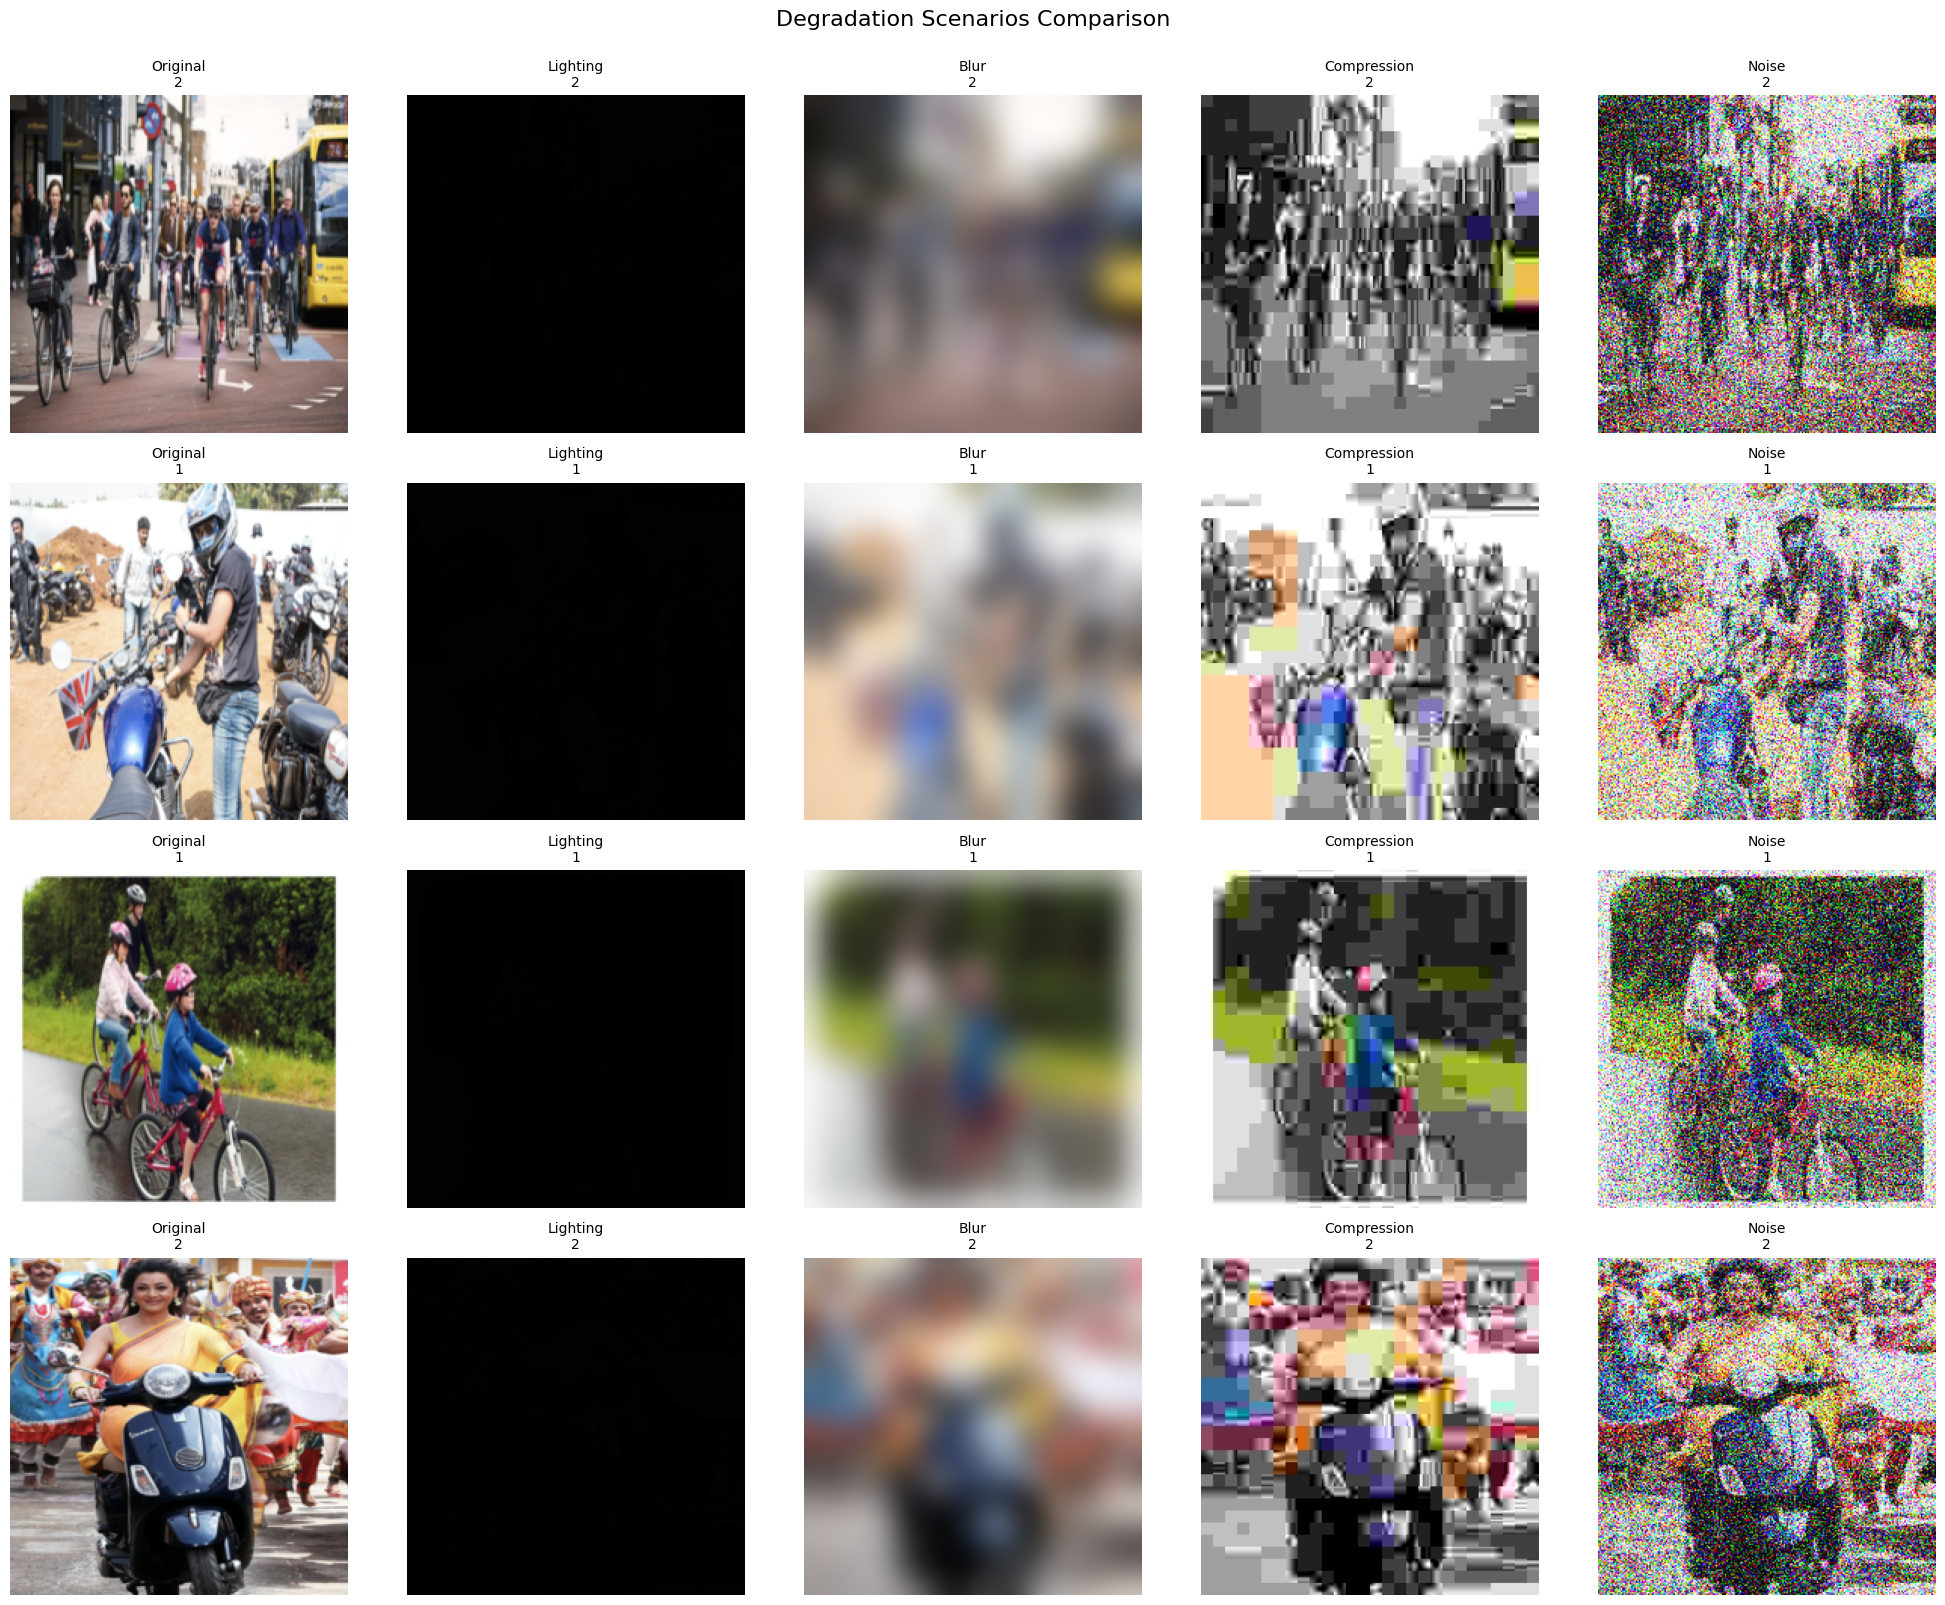

In [ ]:
# Preview: Comparison between Original vs Degradation Scenarios
# Load a few sample images to visualize the degradation effects

# Create a simple transform for original images (no degradation, just resize for display)
preview_base_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

# Load dataset without normalization for visualization
preview_ds = datasets.ImageFolder(BASELINE_DIR, transform=preview_base_tfm)

# Select random samples to display
num_samples = 4
indices = random.sample(range(len(preview_ds)), num_samples)

# Create subplot: 1 column for original + 4 columns for degradations = 5 columns total
fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

degradation_list = [
    ("Lighting", PILLighting(factor=0.01)),
    ("Blur", PILBlur(radius=10.0)),
    ("Compression", PILJPEG(quality=2)),
    ("Noise", PILGaussianNoise(sigma=100.0)),
]

for row, idx in enumerate(indices):
    # Load original image
    orig_img, label = preview_ds[idx]
    class_name = preview_ds.classes[label]

    # Show original
    axes[row, 0].imshow(orig_img)
    axes[row, 0].set_title(f"Original\n{class_name}", fontsize=10)
    axes[row, 0].axis("off")

    # Show each degradation
    for col, (deg_name, deg_transform) in enumerate(degradation_list, start=1):
        degraded_img = deg_transform(orig_img)
        axes[row, col].imshow(degraded_img)
        axes[row, col].set_title(f"{deg_name}\n{class_name}", fontsize=10)
        axes[row, col].axis("off")

plt.suptitle("Degradation Scenarios Comparison", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()



> ## *Skenario lighting, compression, dan noise dimainkan lebih ekstrem untuk mendapatkan efek yang lebih banyak*



## 5) Jalankan Multi-Metrics + Composite Score



> ## **NEW** *Melakukan "kalibrasi" untuk mengetahui nilai normalisasi hard-code terlebih dahulu dan mengecek hasilnya*



In [ ]:
# =============================================================================
# CALIBRATION: Initialize Metric Collector
# =============================================================================

metric_collector = {
    'scenario': [],
    'psi': [],
    'kl': [],
    'class_shift': [],
    'ratio_conf': [],
    'p95_latency': []
}

In [ ]:
# =========================================================
# MULTI-METRIC: batch-level time-series + scenario summary
# Output:
#   1) multi_timeseries_records -> per batch metrics
#   2) df_multi_summary         -> per scenario summary
# =========================================================

rows = []
for scen_name, tfms in scenarios.items():
    scen_ds = datasets.ImageFolder(BASELINE_DIR, transform=tfms)
    scen_loader = DataLoader(
        scen_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
    )

    # --- per-batch processing ---
    scen_all_max_conf = []
    scen_all_pred = []
    scen_lat_ms = []

    for batch_idx, (x, y) in enumerate(scen_loader, start=1):
        x = x.to(device)
        t0 = time.time()
        logits = model(x)
        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.time()

        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        pred  = np.argmax(probs, axis=1)

        max_conf = probs.max(axis=1)  # per sample
        mean_conf = float(max_conf.mean())
        ratio_conf = mean_conf / base_mean_conf if base_mean_conf > 0 else float("nan")

        # drift metrics vs baseline (global)
        psi = psi_score(base_max_conf, max_conf, n_bins=10)
        kl  = kl_divergence(base_max_conf, max_conf, n_bins=10)
        cs  = class_shift(base_pred, pred, NUM_CLASSES)

        lat_ms = float((t1 - t0) * 1000.0)  # per batch latency
        m = ProductionMetrics(
            psi=psi, kl=kl, class_shift=cs, ratio_conf=ratio_conf, p95_latency_ms=lat_ms
        )
        d_prod = compute_d_prod(m)

        # record time-series row
        multi_timeseries_records.append({
            "scenario": scen_name,
            "batch": int(batch_idx),
            "psi": float(psi),
            "kl": float(kl),
            "class_shift": float(cs),
            "confidence_ratio": float(ratio_conf),
            "latency_ms": float(lat_ms),
            "d_prod": float(d_prod),
            "status": status_from_dprod(d_prod),
            "n_samples": int(len(pred)),
        })

        scen_all_max_conf.append(max_conf)
        scen_all_pred.append(pred)
        scen_lat_ms.append(lat_ms)

    # --- scenario-level summary (match prior table style) ---
    scen_all_max_conf = np.concatenate(scen_all_max_conf) if len(scen_all_max_conf) else np.array([])
    scen_all_pred = np.concatenate(scen_all_pred) if len(scen_all_pred) else np.array([])
    scen_lat_ms = np.array(scen_lat_ms) if len(scen_lat_ms) else np.array([])

    if len(scen_all_max_conf) == 0:
        # no data, skip
        continue

    psi_s = psi_score(base_max_conf, scen_all_max_conf, n_bins=10)
    kl_s  = kl_divergence(base_max_conf, scen_all_max_conf, n_bins=10)
    cs_s  = class_shift(base_pred, scen_all_pred, NUM_CLASSES)
    mean_conf_s = float(scen_all_max_conf.mean())
    ratio_conf_s = mean_conf_s / base_mean_conf if base_mean_conf > 0 else float("nan")
    p95_lat_s = float(np.percentile(scen_lat_ms, 95)) if len(scen_lat_ms) else float("nan")

    m_s = ProductionMetrics(
        psi=psi_s, kl=kl_s, class_shift=cs_s, ratio_conf=ratio_conf_s, p95_latency_ms=p95_lat_s
    )
    d_prod_s = compute_d_prod(m_s)

    # === CALIBRATION: Collect metrics ===
    metric_collector['scenario'].append(scen_name)
    metric_collector['psi'].append(float(psi_s))
    metric_collector['kl'].append(float(kl_s))
    metric_collector['class_shift'].append(float(cs_s))
    metric_collector['ratio_conf'].append(float(ratio_conf_s))
    metric_collector['p95_latency'].append(float(p95_lat_s))

    rows.append({
        "Scenario": scen_name,
        "PSI (↑ drift)": float(psi_s),
        "KL (↑ drift)": float(kl_s),
        "Class Shift (0-1)": float(cs_s),
        "Confidence Ratio": float(ratio_conf_s),
        "P95 Latency (ms)": float(p95_lat_s),
        "D_prod (0-1)": float(d_prod_s),
        "Status": status_from_dprod(d_prod_s),
    })

df_multi_summary = pd.DataFrame(rows).sort_values("D_prod (0-1)")
df_multi_summary

Scenario  PSI (↑ drift)  KL (↑ drift)  Class Shift (0-1)  \
4        Gaussian Noise       4.843864      0.655722           0.342105   
1  Lighting Degradation       1.762810      1.688077           0.144737   
2      Blur Degradation       1.125034      0.734624           0.144737   
3    Compression (JPEG)       0.753538      0.054866           0.078947   
0              Baseline       0.000000      0.000000           0.000000   

   Confidence Ratio  P95 Latency (ms)  D_prod (0-1)    Status  
4          0.819175        602.483225      0.291133  Critical  
1          0.954980       1465.726399      0.575484  Critical  
2          1.022961        559.867311      0.713048  Degraded  
3          0.973832        473.764300      0.792842  Degraded  
0          1.000000       1521.179509      0.900000   Healthy



> ## **NEW ** *Kemudian baru dilakukan pencarian nilai normalisasi yang sesuai dengan mencari nilai statistik deskriptif dari multi-metric seperti min, max, mean, p95 latensi, dll*



In [ ]:
# =============================================================================
# CALIBRATION: Analysis and Range Calculation
# =============================================================================

def analyze_and_calibrate_norm(metric_collector: dict,
                               base_lat_ms: np.ndarray,
                               base_mean_conf: float,
                               safety_margin: float = 0.2) -> dict:
    """
    Analyze collected metrics and suggest calibrated NORM ranges.

    Args:
        metric_collector: Dictionary of collected metrics from scenarios
        base_lat_ms: Baseline latency measurements
        base_mean_conf: Baseline mean confidence
        safety_margin: Safety margin as percentage (0.2 = 20%)

    Returns:
        Dictionary of calibrated NORM ranges
    """
    df = pd.DataFrame(metric_collector)

    print("\n" + "="*80)
    print("METRIC DISTRIBUTION ANALYSIS")
    print("="*80)
    print("\nDescriptive Statistics:")
    print(df[['psi', 'kl', 'class_shift', 'ratio_conf', 'p95_latency']].describe())

    # Calculate suggested ranges
    calibrated_norm = {}

    # PSI: [0, max + margin]
    psi_max = df['psi'].max()
    psi_p95 = df['psi'].quantile(0.95)
    calibrated_norm['psi'] = (0.0, psi_max * (1 + safety_margin))
    print(f"\nPSI Analysis:")
    print(f"  Observed range: {df['psi'].min():.4f} - {df['psi'].max():.4f}")
    print(f"  95th percentile: {psi_p95:.4f}")
    print(f"  Literature threshold (significant drift): 0.25")
    print(f"  Suggested NORM range: {calibrated_norm['psi']}")

    # KL: [0, max + margin]
    kl_max = df['kl'].max()
    kl_p95 = df['kl'].quantile(0.95)
    calibrated_norm['kl'] = (0.0, max(0.5, kl_max * (1 + safety_margin)))
    print(f"\nKL Divergence Analysis:")
    print(f"  Observed range: {df['kl'].min():.4f} - {df['kl'].max():.4f}")
    print(f"  95th percentile: {kl_p95:.4f}")
    print(f"  Suggested NORM range: {calibrated_norm['kl']}")

    # Class Shift: [0, max + margin]
    cs_max = df['class_shift'].max()
    cs_p95 = df['class_shift'].quantile(0.95)
    calibrated_norm['class_shift'] = (0.0, min(1.0, cs_max * (1 + safety_margin)))
    print(f"\nClass Shift Analysis:")
    print(f"  Observed range: {df['class_shift'].min():.4f} - {df['class_shift'].max():.4f}")
    print(f"  95th percentile: {cs_p95:.4f}")
    print(f"  Theoretical max: 1.0 (total variation distance)")
    print(f"  Suggested NORM range: {calibrated_norm['class_shift']}")

    # Confidence Ratio: [min - margin, 1.0]
    cr_min = df['ratio_conf'].min()
    cr_p5 = df['ratio_conf'].quantile(0.05)
    calibrated_norm['ratio_conf'] = (max(0.5, cr_min * (1 - safety_margin)), 1.0)
    print(f"\nConfidence Ratio Analysis:")
    print(f"  Baseline: {base_mean_conf:.4f}")
    print(f"  Observed range: {df['ratio_conf'].min():.4f} - {df['ratio_conf'].max():.4f}")
    print(f"  5th percentile: {cr_p5:.4f}")
    print(f"  Suggested NORM range: {calibrated_norm['ratio_conf']}")
    print(f"  Consider: Set lower bound based on business tolerance")
    print(f"           (e.g., 0.85 = max 15% confidence drop acceptable)")

    # P95 Latency: [baseline, max + margin]
    base_p95_lat = np.percentile(base_lat_ms, 95)
    scenario_lat_max = df['p95_latency'].max()
    scenario_lat_p95 = df['p95_latency'].quantile(0.95)
    calibrated_norm['p95_latency_ms'] = (base_p95_lat, scenario_lat_max * (1 + safety_margin))
    print(f"\nP95 Latency Analysis:")
    print(f"  Baseline P95: {base_p95_lat:.2f} ms")
    print(f"  Scenario range: {df['p95_latency'].min():.2f} - {df['p95_latency'].max():.2f} ms")
    print(f"  Scenario P95: {scenario_lat_p95:.2f} ms")
    print(f"  Suggested NORM range: ({calibrated_norm['p95_latency_ms'][0]:.2f}, {calibrated_norm['p95_latency_ms'][1]:.2f}) ms")
    print(f"  Consider: Set upper bound based on SLA requirement")

    print("\n" + "="*80)
    print("CALIBRATED NORM CONFIGURATION")
    print("="*80)
    print("\nCopy this to replace your NORM dict:\n")
    print("NORM_CALIBRATED = {")
    for key, (lo, hi) in calibrated_norm.items():
        print(f"    \"{key}\": ({lo:.4f}, {hi:.4f}),")
    print("}")

    return calibrated_norm

# Run calibration analysis
NORM_CALIBRATED = analyze_and_calibrate_norm(
    metric_collector,
    base_lat_ms,
    base_mean_conf,
    safety_margin=0.2  # 20% safety margin
)


METRIC DISTRIBUTION ANALYSIS

Descriptive Statistics:
            psi        kl  class_shift  ratio_conf  p95_latency
count  5.000000  5.000000     5.000000    5.000000     5.000000
mean   1.697049  0.626658     0.142105    0.954190   924.604149
std    1.871106  0.681681     0.126685    0.079755   521.719961
min    0.000000  0.000000     0.000000    0.819175   473.764300
25%    0.753538  0.054866     0.078947    0.954980   559.867311
50%    1.125034  0.655722     0.144737    0.973832   602.483225
75%    1.762810  0.734624     0.144737    1.000000  1465.726399
max    4.843864  1.688077     0.342105    1.022961  1521.179509

PSI Analysis:
  Observed range: 0.0000 - 4.8439
  95th percentile: 4.2277
  Literature threshold (significant drift): 0.25
  Suggested NORM range: (0.0, 5.812636312115287)

KL Divergence Analysis:
  Observed range: 0.0000 - 1.6881
  95th percentile: 1.4974
  Suggested NORM range: (0.0, 2.0256928365523548)

Class Shift Analysis:
  Observed range: 0.0000 - 0.3421
  95



> ## **NEW ** *Dijalankan pencarian nilai composite dengan range normalisasi yang didaptkan dari run sebelumnya yaitu berbasis min, max dan 20% buffer (untuk mengcover skenario anomali)*



In [ ]:
# =============================================================================
# CALIBRATION: Recompute D_prod with Calibrated NORM
# =============================================================================

# Update the NORM dictionary
NORM = NORM_CALIBRATED

# Re-compute D_prod for all scenarios
print("\n" + "="*80)
print("RECOMPUTING WITH CALIBRATED NORM")
print("="*80)

rows_calibrated = []
for i, scen_name in enumerate(metric_collector['scenario']):
    m = ProductionMetrics(
        psi=metric_collector['psi'][i],
        kl=metric_collector['kl'][i],
        class_shift=metric_collector['class_shift'][i],
        ratio_conf=metric_collector['ratio_conf'][i],
        p95_latency_ms=metric_collector['p95_latency'][i]
    )
    d_prod_calibrated = compute_d_prod(m)

    # Get original D_prod from df_multi_summary
    orig_row = df_multi_summary[df_multi_summary['Scenario'] == scen_name].iloc[0]

    rows_calibrated.append({
        "Scenario": scen_name,
        "PSI": metric_collector['psi'][i],
        "KL": metric_collector['kl'][i],
        "Class Shift": metric_collector['class_shift'][i],
        "Conf Ratio": metric_collector['ratio_conf'][i],
        "P95 Lat (ms)": metric_collector['p95_latency'][i],
        "D_prod (Original)": orig_row["D_prod (0-1)"],
        "D_prod (Calibrated)": d_prod_calibrated,
        "Status": status_from_dprod(d_prod_calibrated),
    })

df_calibrated = pd.DataFrame(rows_calibrated).sort_values("D_prod (Calibrated)")
print("\nComparison: Original vs Calibrated D_prod")
display(df_calibrated)

# Show differences
print("\nD_prod Score Changes:")
for _, row in df_calibrated.iterrows():
    diff = row["D_prod (Calibrated)"] - row["D_prod (Original)"]
    print(f"  {row['Scenario']:25s}: {row['D_prod (Original)']:.3f} → {row['D_prod (Calibrated)']:.3f} (Δ {diff:+.3f})")


RECOMPUTING WITH CALIBRATED NORM

Comparison: Original vs Calibrated D_prod


Scenario       PSI        KL  Class Shift  Conf Ratio  \
4        Gaussian Noise  4.843864  0.655722     0.342105    0.819175   
1  Lighting Degradation  1.762810  1.688077     0.144737    0.954980   
3    Compression (JPEG)  0.753538  0.054866     0.078947    0.973832   
2      Blur Degradation  1.125034  0.734624     0.144737    1.022961   
0              Baseline  0.000000  0.000000     0.000000    1.000000   

   P95 Lat (ms)  D_prod (Original)  D_prod (Calibrated)    Status  
4    602.483225           0.291133             0.493115  Critical  
1   1465.726399           0.575484             0.763671  Degraded  
3    473.764300           0.792842             0.921564   Healthy  
2    559.867311           0.713048             0.924269   Healthy  
0   1521.179509           0.900000             0.961468   Healthy


D_prod Score Changes:
  Gaussian Noise           : 0.291 → 0.493 (Δ +0.202)
  Lighting Degradation     : 0.575 → 0.764 (Δ +0.188)
  Compression (JPEG)       : 0.793 → 0.922 (Δ +0.129)
  Blur Degradation         : 0.713 → 0.924 (Δ +0.211)
  Baseline                 : 0.900 → 0.961 (Δ +0.061)




> ## **NEW ** *Visualization tambahan*



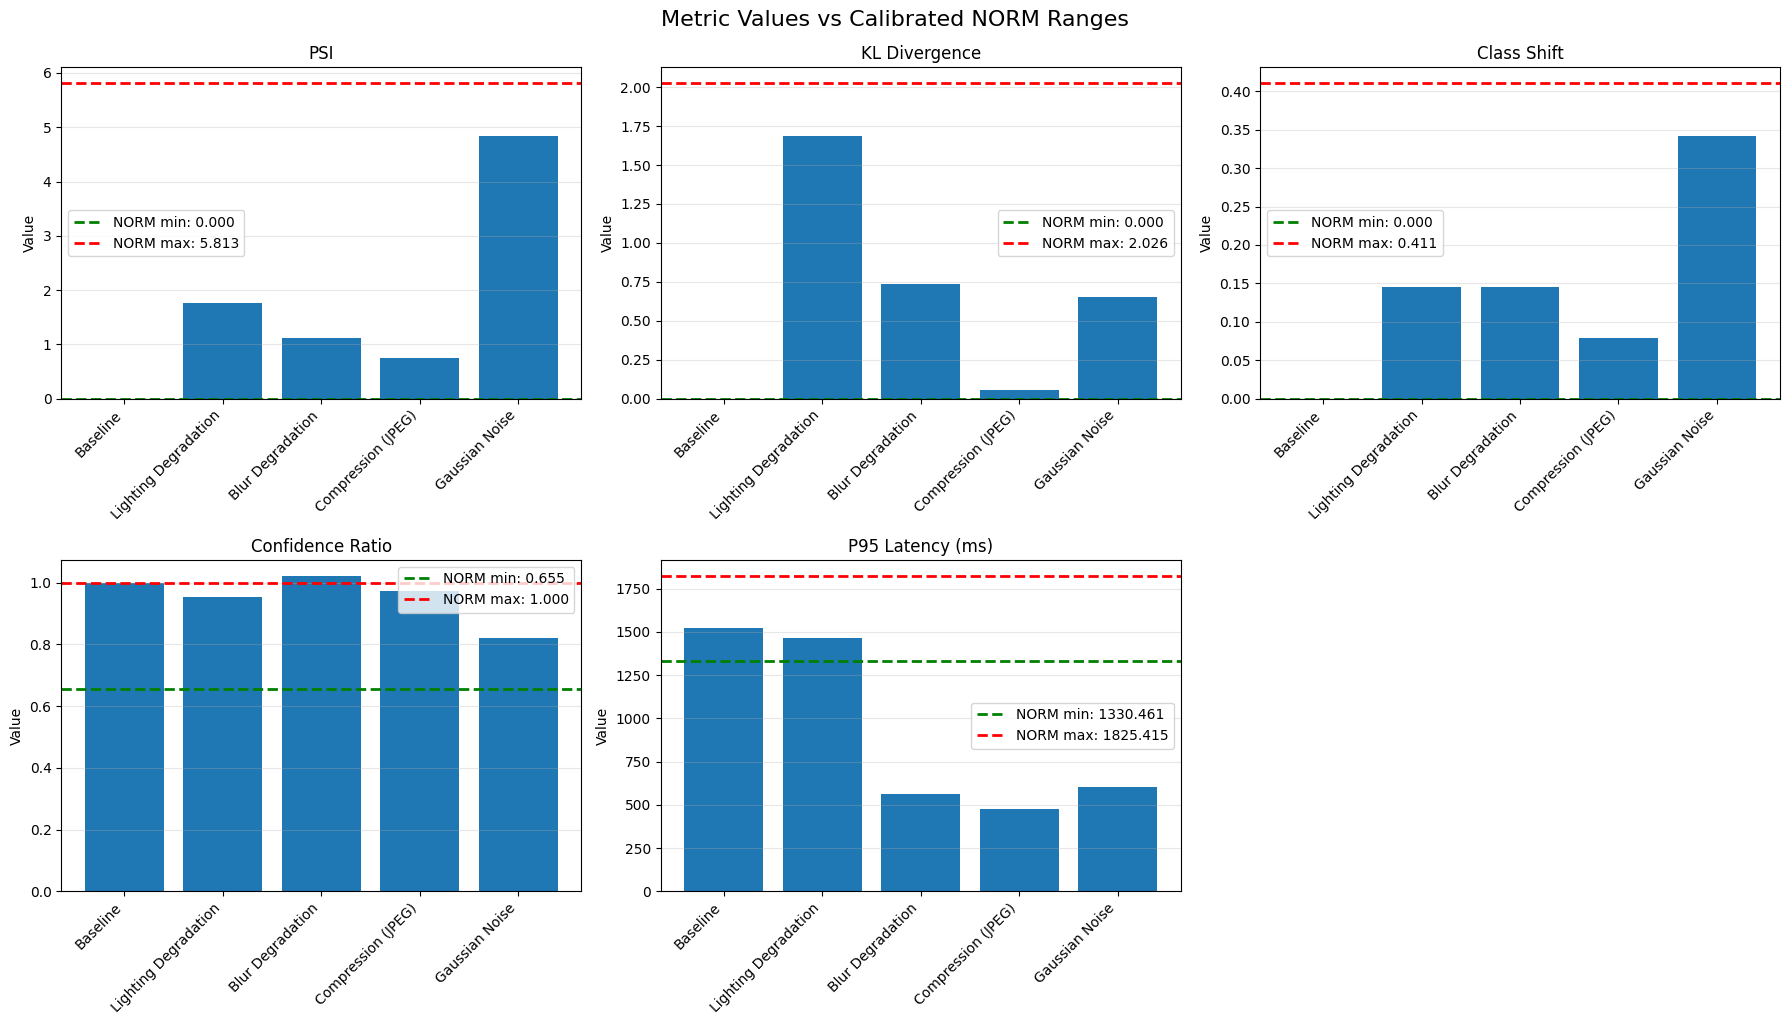

In [ ]:
# =============================================================================
# CALIBRATION: Visualization of Normalization Impact
# =============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['psi', 'kl', 'class_shift', 'ratio_conf', 'p95_latency']
titles = ['PSI', 'KL Divergence', 'Class Shift', 'Confidence Ratio', 'P95 Latency (ms)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 3, idx % 3]

    # Get data
    scenarios = metric_collector['scenario']
    values = metric_collector[metric]

    # Plot bars
    bars = ax.bar(range(len(scenarios)), values)

    # Add NORM range as horizontal lines
    norm_key = metric if metric != 'p95_latency' else 'p95_latency_ms'
    lo, hi = NORM_CALIBRATED[norm_key]
    ax.axhline(y=lo, color='green', linestyle='--', label=f'NORM min: {lo:.3f}', linewidth=2)
    ax.axhline(y=hi, color='red', linestyle='--', label=f'NORM max: {hi:.3f}', linewidth=2)

    # Formatting
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.suptitle('Metric Values vs Calibrated NORM Ranges', fontsize=16, y=1.02)
plt.show()

## 6) Visualisasi (Opsional)

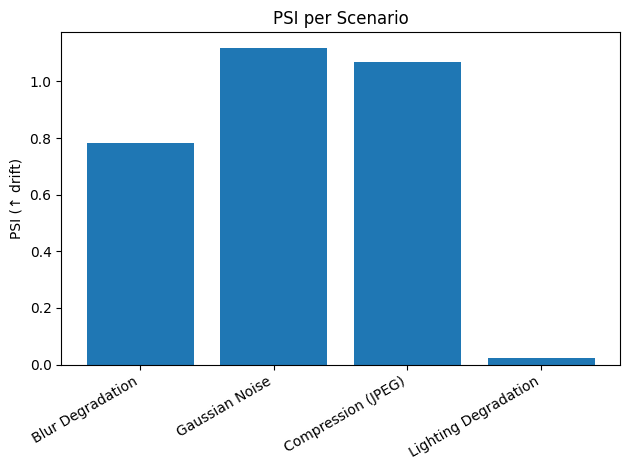

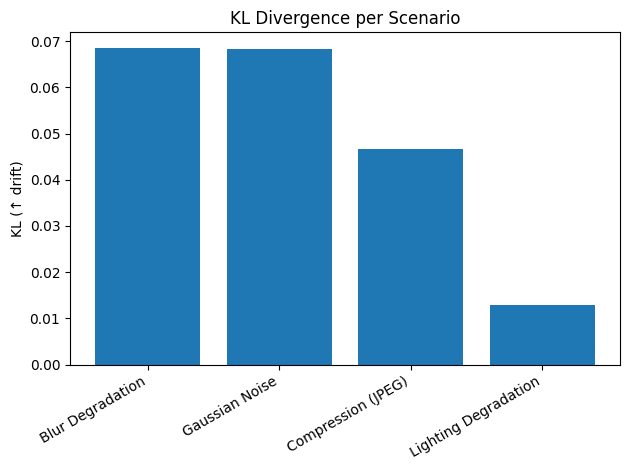

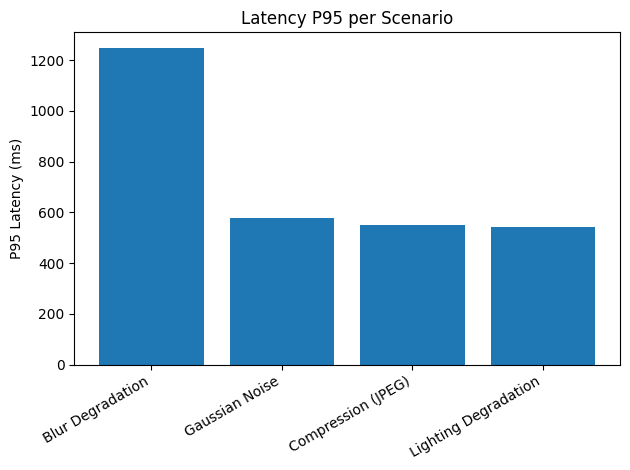

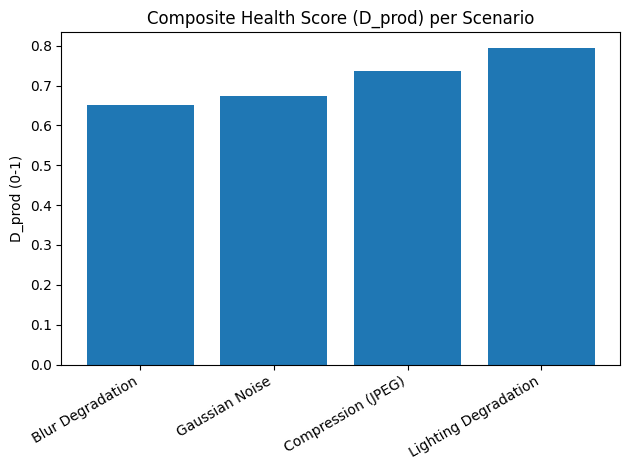

In [ ]:
# def barplot(metric_col, title):
#     fig = plt.figure()
#     plt.bar(df_multi["Scenario"], df_multi[metric_col])
#     plt.xticks(rotation=30, ha="right")
#     plt.title(title)
#     plt.ylabel(metric_col)
#     plt.tight_layout()
#     plt.show()

# barplot("PSI (↑ drift)", "PSI per Scenario")
# barplot("KL (↑ drift)", "KL Divergence per Scenario")
# barplot("P95 Latency (ms)", "Latency P95 per Scenario")
# barplot("D_prod (0-1)", "Composite Health Score (D_prod) per Scenario")


In [ ]:
# import os
# import pandas as pd

# # ==============================
# # EXPORT MULTI-METRIC TIMESERIES
# # ==============================
# multi_df = pd.DataFrame(multi_timeseries_records)

# os.makedirs("./outputs", exist_ok=True)
# os.makedirs("./artifacts", exist_ok=True)

# assert len(multi_df) > 0, "❌ multi_timeseries_records kosong! Pastikan loop batch berjalan."

# multi_df.to_csv("./outputs/multi_timeseries.csv", index=False)
# multi_df.to_parquet("./outputs/multi_timeseries.parquet", index=False)

# # optional duplicate to artifacts/
# multi_df.to_csv("./artifacts/multi_timeseries.csv", index=False)
# multi_df.to_parquet("./artifacts/multi_timeseries.parquet", index=False)

# print("✅ Multi-metric time-series exported")
# display(multi_df.head())
